In [70]:
import numpy as np
import wurtzite as wzt
import dataclasses

In [28]:
l0 = wzt.generate.create_lattice(
    dimensions=(7, 7, 2),  #  The number of cells
    cell="B4_ZnS",
)

Reading bond: 577/577

In [57]:
NU = 0.35
BETA_ONES = np.eye(3)

def love(x: np.ndarray, be: float, bz: float) -> np.ndarray:
    """
    Calculates love function.

    NOTE: ux moved by a constant value according to the ICMM8 paper. 
    
    :param i: the position of the atom in the list of the atoms 
    :return: love function for the given parameters (n_points, 3)
    """
    x1 = x[..., 0]  # (n_atoms, )
    x2 = x[..., 1]  # (n_atoms, )
    r2 = x1**2 + x2**2
    r = np.sqrt(r2)
    x1_norm = x1/r
    x2_norm = x2/r
    r02 = RADIUS_FACTOR*be**2

    ux = be/(2*np.pi)*(np.arctan2(x2_norm, x1_norm) + x1_norm*x2_norm/(2.0*(1-NU))) - be/2
    uy = -be/(8*np.pi*(1-NU))*((1.0-2*NU)*np.log(r2/r02) - 2*(x2_norm**2))
    uz = bz/(2*np.pi)*np.arctan2(x2_norm, x1_norm) - bz/2

    ux = ux.reshape(-1, 1)  # (natoms, 1)
    uy = uy.reshape(-1, 1)  # (natoms, 1)
    uz = uz.reshape(-1, 1)  # (natoms, 1)
    return np.column_stack((ux, uy, uz))  # (natoms, 3)


def beta(x: np.ndarray, be: float, bz: float) -> np.ndarray:
    """
    Calculates Beta function.
    Note: this function will return 1 (diagonal) for atoms which are in the
    center of dislocation core.
    """
    x = np.asarray(x)
    if len(x.shape) == 1:
        x = x[np.newaxis, ...]
    x1 = x[..., 0]  # (n_atoms, )
    x2 = x[..., 1]
    x1_2 = x1**2
    x2_2 = x2**2
    r2 = x1_2+x2_2

    a = be/(4*np.pi*(1.0-NU)*r2*r2)
    
    # du / dx1
    b11 = (-1)*a*x2*((3.0-2.0*NU)*x1_2 + (1.0-2.0*NU)*x2_2)  # (natoms, )
    b21 = (-1)*a*x1*((1.0-2.0*NU)*x1_2 + (3.0-2.0*NU)*x2_2)
    b31 = (-1)*bz/(2.0*np.pi) * x2/r2
    
    # du / dx2
    b12 = a*x1*((3.0-2.0*NU)*x1_2 + (1.0-2.0*NU)*x2_2)
    b22 = a*x2*((1.0+2.0*NU)*x1_2-(1.0-2.0*NU)*x2_2)
    b32 = bz/(2.0*np.pi) * x1/r2
    result = np.repeat(BETA_ONES.copy()[np.newaxis, ...], len(x1), axis=0)
    result[:, 0, 0] = b11
    result[:, 1, 0] = b21
    result[:, 2, 0] = b31
    result[:, 0, 1] = b12
    result[:, 1, 1] = b22
    result[:, 2, 1] = b32

    # Atoms in the center of dislocation core: just equal 1
    # (1-beta will be zero)
    core_center_atoms = r2 < 1e-15  # (natoms, )
    result[core_center_atoms, :, :] = BETA_ONES
    return result  # (natoms, 3, 3)

In [84]:
def display_vector_2d(ax, a, b, **kwargs):
    a_x, a_y = a
    b_x, b_y = b
    d_x, d_y = b_x-a_x, b_y-a_y
    ax.arrow(a_x, a_y, d_x, d_y, length_includes_head=True, **kwargs)
    return ax

In [63]:
dislocations = [
    wzt.model.DislocationDef(
        b=[1, 0, 0],
        position=[5, 6, 7.5],
        plane=(0, 0, 1),
        label="1", # "$d_1$: type: 8",
        color="brown"
    ),
    wzt.model.DislocationDef(
        b=[1, 0, 0],
        position=[7, 9, 7.5],
        plane=(0, 0, 1),
        label="2", # "$d_1$: type: 8",
        color="brown"
    )
]

In [74]:
def to_cartesian(lattice, dislocation):
    return lattice.cell.to_cartesian_indices(dislocation.b)

In [105]:
beta1 = beta(dislocations[0].position, l0.cell.to_cartesian_indices(dislocations[0].b)[0], bz=0)
F_1_inv = (BETA_ONES-beta1)
F_1 = np.linalg.inv(F_1_inv[0, :2, :2])

b2_rotated = F_1.dot(to_cartesian(l0, dislocations[1])[:2]).squeeze()
b2_rotated = b2_rotated/np.linalg.norm(b2_rotated)
b2_rotated

array([ 0.99832247, -0.05789853])

Text(0.5, 1.0, 'Initial configuration')

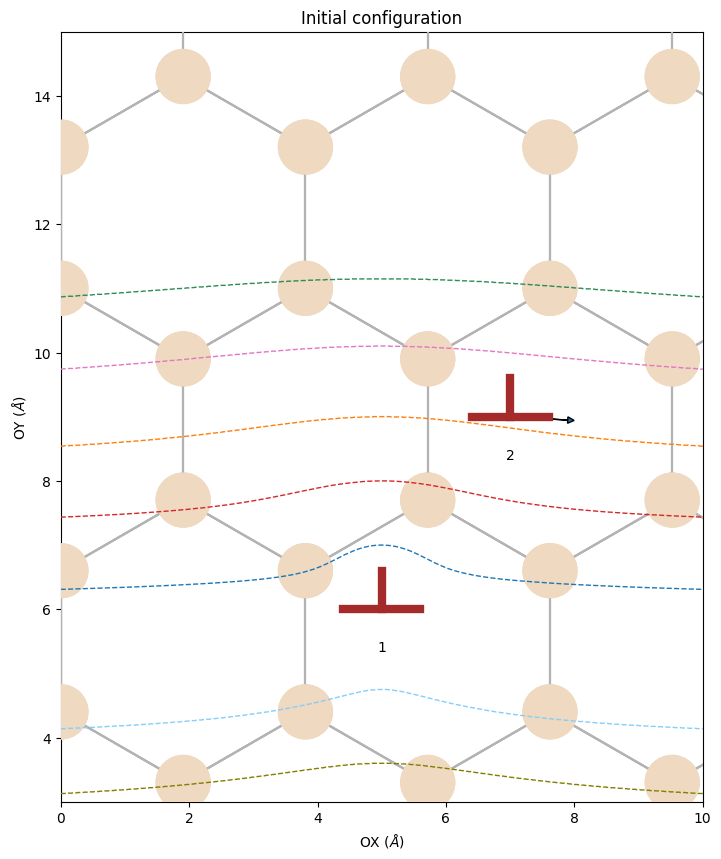

In [106]:
fig, ax = wzt.visualization.plot_atoms_2d(l0, figsize=(10, 10), alpha=0.3)
ax.set_aspect("equal")
ax.set_xlim([0, 10])
ax.set_ylim([3 ,15])
for d in dislocations:
    wzt.visualization.display_tee_2d(ax, d, scale=0.6, line_width=10)

# offset = np.asarray([-0.35, 0.0, 0.0])  # TODO determine that by interpolating the initial location of the 
# d_offseted = dataclasses.replace(d, position=d.position+offset)



xlim = -12, 15
for y0, ylim, color in [
        (1.0, (-1, 1), "tab:blue"), 
        (2.0, (0, 3.0), "tab:red"), 
        (3.0, (0, 10.0), "tab:orange"),
        (4.1, (0, 10.0), "tab:pink"),
        (5.15, (0, 10.0), "seagreen"),
        (-1.25, (-10.0, 0.0), "lightskyblue"),
        (-2.4, (-10.0, 0.0), "olive"),
]:
    plane_d_x, plane_d_y = wzt.dislocations.get_crystal_surface_oxy(
        position=dislocations[0].position, x0=0.0, y0=y0, xlim=xlim, ylim=ylim, bx=to_cartesian(l0, dislocations[0])[0])
    ax.plot(plane_d_x, plane_d_y, lw=1, ls="--", zorder=1500, color=color)


display_vector_2d(ax, dislocations[1].position[:2], dislocations[1].position[:2] + b2_rotated[:2], head_width=0.1, head_length=0.1)
ax.set_title("Initial configuration")